Let's try out these three types of models on the open dataset from Kaggle competition [WSDM - KKBox's Churn Prediction Challenge](https://www.kaggle.com/c/kkbox-churn-prediction-challenge/overview/). In this dataset we have users of KKBOX music streaming with their attributes, transaction histories and churn label -- whether a customer will churn out in the next 30 days. Due to the nature of the business, customers can put subscription on pause or change subscription interval, which makes this dataset both -- contractual and non-contractual simultaneously. Meaning that customer who puts subsciprtion on pause doesn't neceserelly churned out unlike situation in telecom.

The dataset contains 3 tables of our interset:
1. Members. Information about customers, such as gender, age, etc.
2. Train. Churn label for each customer.
3. Transactions. Historical transactions with dates, subscription plans, etc.


In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
%matplotlib inline
plt.style.use('ggplot')
# import seaborn as sns
import datetime


pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

For each table let's do some basic EDA and cleaning.


In [2]:

members = pd.read_csv('data/members_v3.csv', 
                      sep=',', 
                      parse_dates=['registration_init_time'],
                      dtype={'msno': str, 
                             'city': np.int8, 
                             'gender': CategoricalDtype(categories=['female', 'male']), 
                             'registered_via': np.int8, 
                             'registration_init_time': str}
                     )




In [3]:
members.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6769473 entries, 0 to 6769472
Data columns (total 6 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   city                    int8          
 2   bd                      int64         
 3   gender                  category      
 4   registered_via          int8          
 5   registration_init_time  datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(1), int8(2), object(1)
memory usage: 174.3+ MB


In [4]:
print(members.shape)

members.head()


(6769473, 6)


,msno,city,bd,gender,registered_via,registration_init_time
0,Rb9UwLQTrxzBVwCB6+bCcSQWZ9JiNLC9dXtM1oEsZA8=,1,0,NaN,11,2011-09-11
1,+tJonkh+O1CA796Fm5X60UMOtB6POHAwPjbTRVl/EuU=,1,0,NaN,7,2011-09-14
2,cV358ssn7a0f7jZOwGNWS07wCKVqxyiImJUX6xcIwKw=,1,0,NaN,11,2011-09-15
3,9bzDeJP6sQodK73K5CBlJ6fgIQzPeLnRl0p5B77XP+g=,1,0,NaN,11,2011-09-15
4,WFLY3s7z4EZsieHCt63XrsdtfTEmJ+2PnnKLH5GY4Tk=,6,32,female,9,2011-09-15


Check that each row has unique customer_id (msno)

In [5]:
members['msno'].nunique()


6769473

There are customers yonger than 10 and older than 100 years old. Let's change these values to NaN


In [3]:
members.loc[members['bd'] < 10,'bd'] = np.nan
members.loc[members['bd'] > 100,'bd'] = np.nan


Age and gender are only have NAs

In [7]:
members.isnull().sum()


msno                            0
city                            0
bd                        4546765
gender                    4429505
registered_via                  0
registration_init_time          0
dtype: int64

City 1 dominates

In [8]:
(members.groupby(['city'])['msno'].count() / members.shape[0]).sort_values(ascending=False).round(2)


city
1     0.71
5     0.06
13    0.05
4     0.04
22    0.03
15    0.03
6     0.02
14    0.01
12    0.01
9     0.01
11    0.01
8     0.01
18    0.01
10    0.00
21    0.00
17    0.00
3     0.00
7     0.00
16    0.00
20    0.00
19    0.00
Name: msno, dtype: float64

Age distribution. Main portion of users is between 20 and 40 y.o.

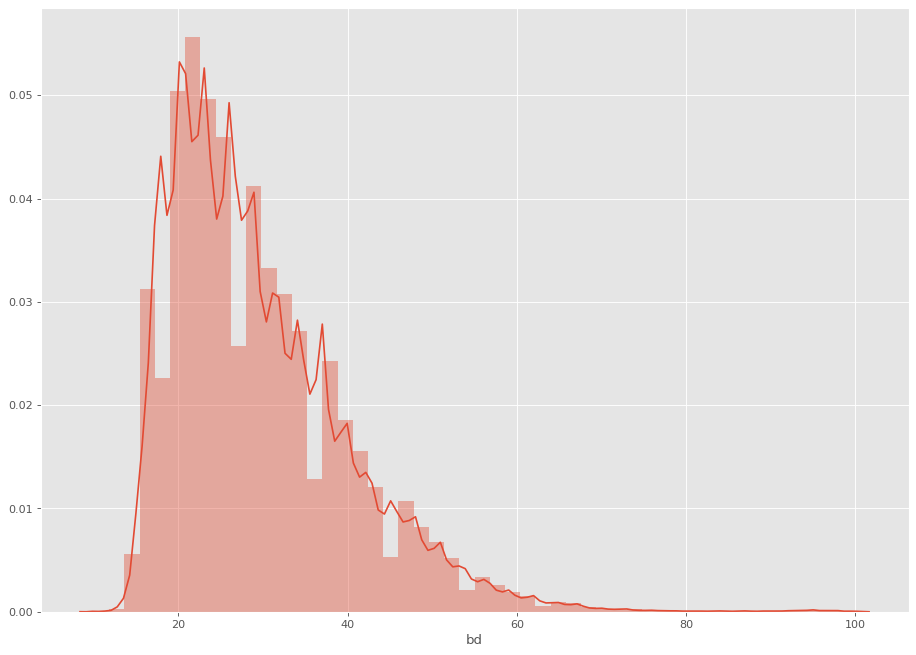

In [11]:
plt.figure(figsize=(14, 10), dpi=80)
sns.distplot(members['bd'].dropna())
plt.show()



Gender equally splitted

In [73]:
(members.groupby(['gender'])['msno'].count() / members.dropna(subset=['gender']).shape[0]).sort_values(ascending=False).round(2)


gender
male      0.51
female    0.49
Name: msno, dtype: float64

We see different channels of attraction in the dataset

In [72]:
(members.groupby(['registered_via'])['msno'].count() / members.shape[0]).sort_values(ascending=False).round(2)


registered_via
 4     0.41
 3     0.24
 9     0.22
 7     0.12
 11    0.00
 13    0.00
 8     0.00
 5     0.00
 17    0.00
 2     0.00
 6     0.00
 19    0.00
 16    0.00
 14    0.00
 1     0.00
 10    0.00
 18    0.00
-1     0.00
Name: msno, dtype: float64

In [75]:
(members.groupby(['registration_init_time'])['msno'].count() / members.shape[0]).sort_values(ascending=False).round(2)


registration_init_time
2015-10-09    0.0
2015-10-10    0.0
2015-11-21    0.0
2015-11-07    0.0
2015-10-17    0.0
             ... 
2004-05-21    0.0
2004-05-30    0.0
2004-06-13    0.0
2004-05-27    0.0
2004-05-25    0.0
Name: msno, Length: 4782, dtype: float64

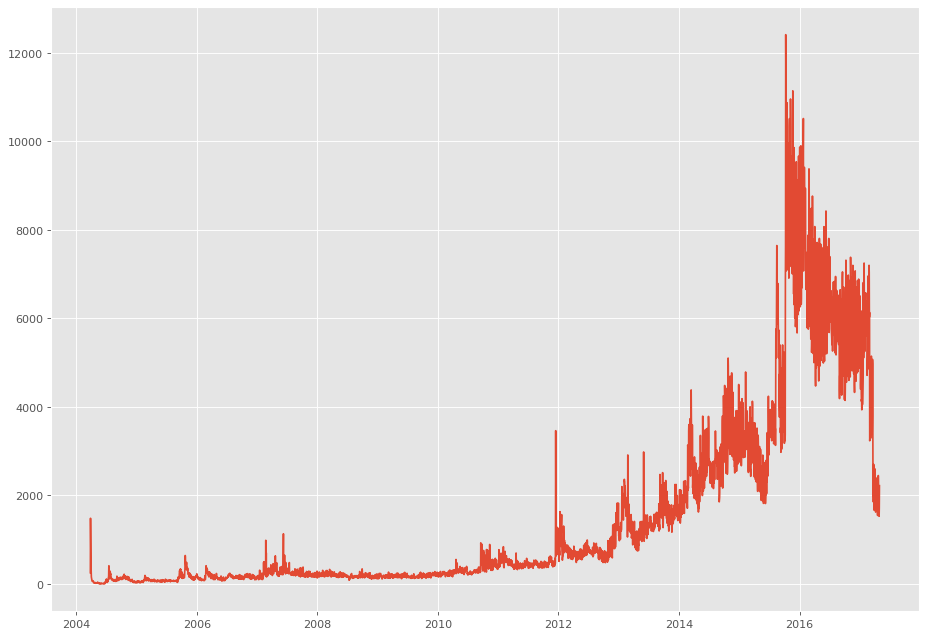

In [78]:
plt.figure(figsize=(14, 10), dpi=80)
plt.plot(members.groupby(['registration_init_time'])['msno'].count())
plt.show()


In [4]:
train = pd.read_csv('data/train.csv', 
                    sep=',', 
                    dtype={'msno': str, 
                           'is_churn': np.int8}
                     )


In [30]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   msno      992931 non-null  object
 1   is_churn  992931 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 8.5+ MB


In [31]:
print(train.shape)

train.head()


(992931, 2)


,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


Check that each row has unique customer_id (msno)

In [80]:
train['msno'].nunique()


992931

No NAs

In [91]:
train.isnull().sum()


msno        0
is_churn    0
dtype: int64

Only 6% churned out

In [81]:
(train.groupby(['is_churn'])['msno'].count() / train.shape[0]).sort_values(ascending=False).round(2)


is_churn
0    0.94
1    0.06
Name: msno, dtype: float64

In [5]:
transactions = pd.read_csv('data/transactions.csv', 
                           sep=',', 
                           parse_dates=['transaction_date', 'membership_expire_date'],
                           dtype={'msno': str, 
                                  'payment_method_id': np.int8, 
                                  'payment_plan_days': np.int16, 
                                  'plan_list_price': np.int16, 
                                  'actual_amount_paid': np.int16, 
                                  'is_auto_renew': np.int8, 
                                  'transaction_date': str, 
                                  'membership_expire_date': str, 
                                  'is_cancel': np.int8
                                },
                     )


In [49]:
transactions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   msno                    object        
 1   payment_method_id       int8          
 2   payment_plan_days       int16         
 3   plan_list_price         int16         
 4   actual_amount_paid      int16         
 5   is_auto_renew           int8          
 6   transaction_date        datetime64[ns]
 7   membership_expire_date  datetime64[ns]
 8   is_cancel               int8          
dtypes: datetime64[ns](2), int16(3), int8(3), object(1)
memory usage: 678.1+ MB


In [52]:
print(transactions.shape)

transactions.head()


(21547746, 9)


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-09-30,2015-11-01,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,2015-09-30,2015-10-31,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,2015-09-30,2016-04-27,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,2015-09-30,2015-11-28,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,2015-09-30,2015-11-21,0


Transactions with expiration before 2015 look unclean, so let's change it with NaN

In [8]:
transactions.loc[transactions['membership_expire_date'] < '2015-01-01','membership_expire_date'] = np.nan


In [111]:
transactions.isnull().sum()


msno                         0
payment_method_id            0
payment_plan_days            0
plan_list_price              0
actual_amount_paid           0
is_auto_renew                0
transaction_date             0
membership_expire_date    9840
is_cancel                    0
dtype: int64

Orders per customer distribution

In [88]:
transactions.groupby(['msno'])['msno'].count().describe().round(0)


count    2363626.0
mean           9.0
std            9.0
min            1.0
25%            1.0
50%            5.0
75%           16.0
max           71.0
Name: msno, dtype: float64

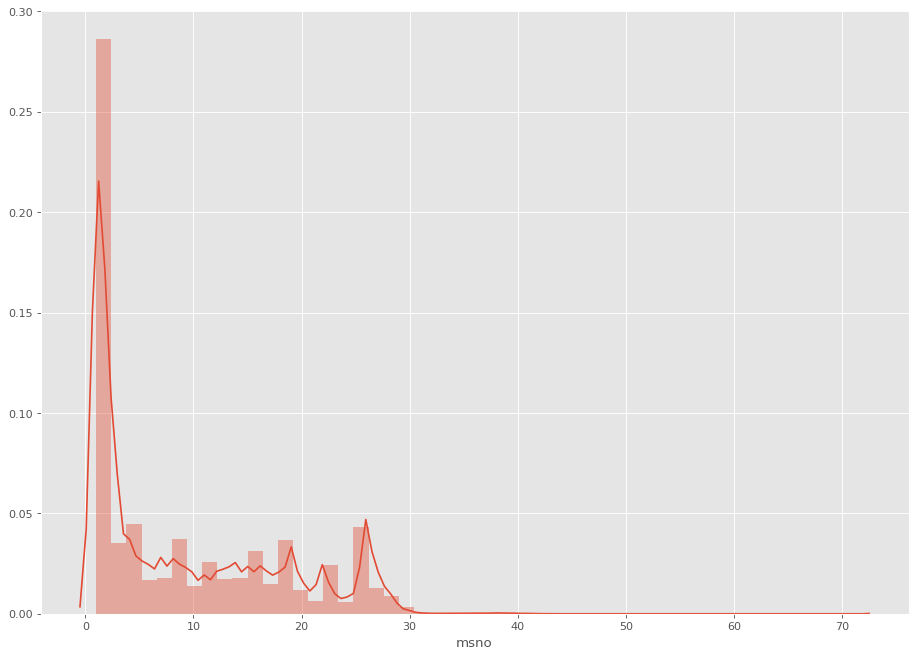

In [87]:
plt.figure(figsize=(14, 10), dpi=80)
sns.distplot(transactions.groupby(['msno'])['msno'].count())
plt.show()


In [89]:
(transactions.groupby(['payment_method_id'])['msno'].count() / transactions.shape[0]).sort_values(ascending=False).round(2)


payment_method_id
41    0.53
40    0.10
38    0.08
39    0.07
37    0.05
36    0.04
34    0.03
35    0.03
33    0.02
31    0.01
30    0.01
32    0.01
29    0.01
28    0.00
27    0.00
23    0.00
19    0.00
20    0.00
21    0.00
22    0.00
24    0.00
18    0.00
25    0.00
14    0.00
16    0.00
17    0.00
13    0.00
26    0.00
12    0.00
11    0.00
15    0.00
10    0.00
7     0.00
8     0.00
5     0.00
6     0.00
3     0.00
2     0.00
4     0.00
1     0.00
Name: msno, dtype: float64

In [90]:
(transactions.groupby(['payment_plan_days'])['msno'].count() / transactions.shape[0]).sort_values(ascending=False).round(2)


payment_plan_days
30     0.88
0      0.04
31     0.04
7      0.03
195    0.01
410    0.00
180    0.00
10     0.00
100    0.00
90     0.00
395    0.00
120    0.00
60     0.00
14     0.00
200    0.00
360    0.00
1      0.00
400    0.00
450    0.00
240    0.00
45     0.00
21     0.00
35     0.00
70     0.00
80     0.00
99     0.00
365    0.00
270    0.00
66     0.00
110    0.00
230    0.00
2      0.00
3      0.00
15     0.00
415    0.00
425    0.00
95     0.00
Name: msno, dtype: float64

In [93]:
(transactions.groupby(['plan_list_price'])['msno'].count() / transactions.shape[0]).sort_values(ascending=False).round(2)


plan_list_price
149     0.58
99      0.23
0       0.07
129     0.05
180     0.03
150     0.02
894     0.01
100     0.00
1788    0.00
536     0.00
119     0.00
480     0.00
1599    0.00
477     0.00
35      0.00
799     0.00
300     0.00
120     0.00
1200    0.00
298     0.00
930     0.00
447     0.00
134     0.00
450     0.00
500     0.00
50      0.00
699     0.00
1000    0.00
124     0.00
350     0.00
131     0.00
105     0.00
400     0.00
70      0.00
143     0.00
2000    0.00
1       0.00
1150    0.00
126     0.00
596     0.00
10      0.00
15      0.00
210     0.00
265     0.00
1520    0.00
800     0.00
30      0.00
760     0.00
600     0.00
1825    0.00
44      0.00
Name: msno, dtype: float64

In [94]:
(transactions.groupby(['actual_amount_paid'])['msno'].count() / transactions.shape[0]).sort_values(ascending=False).round(2)


actual_amount_paid
149     0.58
99      0.23
0       0.06
129     0.05
180     0.03
150     0.02
119     0.02
894     0.01
1788    0.00
100     0.00
536     0.00
480     0.00
1599    0.00
477     0.00
35      0.00
799     0.00
300     0.00
1200    0.00
298     0.00
930     0.00
120     0.00
134     0.00
447     0.00
450     0.00
500     0.00
50      0.00
699     0.00
1000    0.00
350     0.00
124     0.00
131     0.00
105     0.00
400     0.00
70      0.00
143     0.00
2000    0.00
1       0.00
1150    0.00
127     0.00
596     0.00
10      0.00
15      0.00
210     0.00
265     0.00
1520    0.00
800     0.00
30      0.00
41      0.00
760     0.00
600     0.00
1825    0.00
1799    0.00
849     0.00
1800    0.00
45      0.00
1802    0.00
890     0.00
Name: msno, dtype: float64

In [95]:
(transactions.groupby(['is_auto_renew'])['msno'].count() / transactions.shape[0]).sort_values(ascending=False).round(2)


is_auto_renew
1    0.85
0    0.15
Name: msno, dtype: float64

Transactions dynamics. We can see spikes at the beginning of each month.

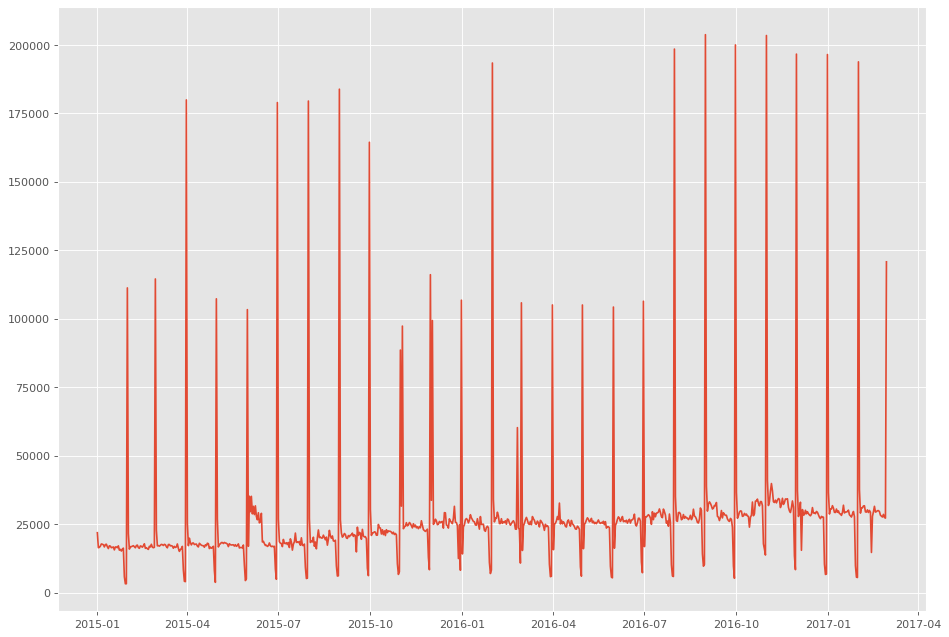

In [96]:
plt.figure(figsize=(14, 10), dpi=80)
plt.plot(transactions.groupby(['transaction_date'])['msno'].count())
plt.show()


Let's group transactions to months to be able to see the trend.

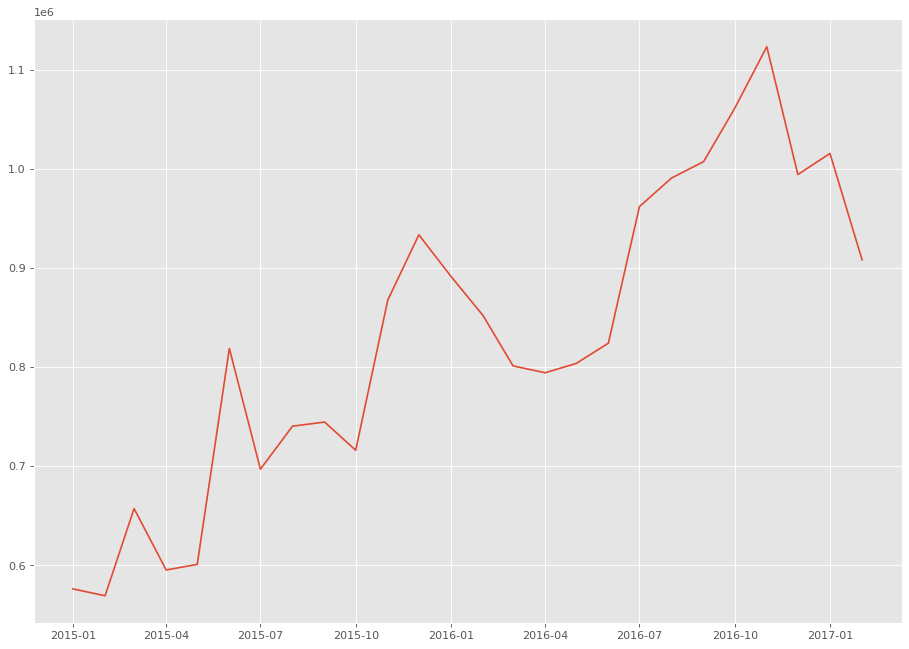

In [105]:
plt.figure(figsize=(14, 10), dpi=80)
plt.plot(transactions
         .assign(transaction_month=lambda x: x['transaction_date'].dt.strftime('%Y-%m-01').astype(np.datetime64))
         .groupby(['transaction_month'])['msno']
         .count()
        )
plt.show()


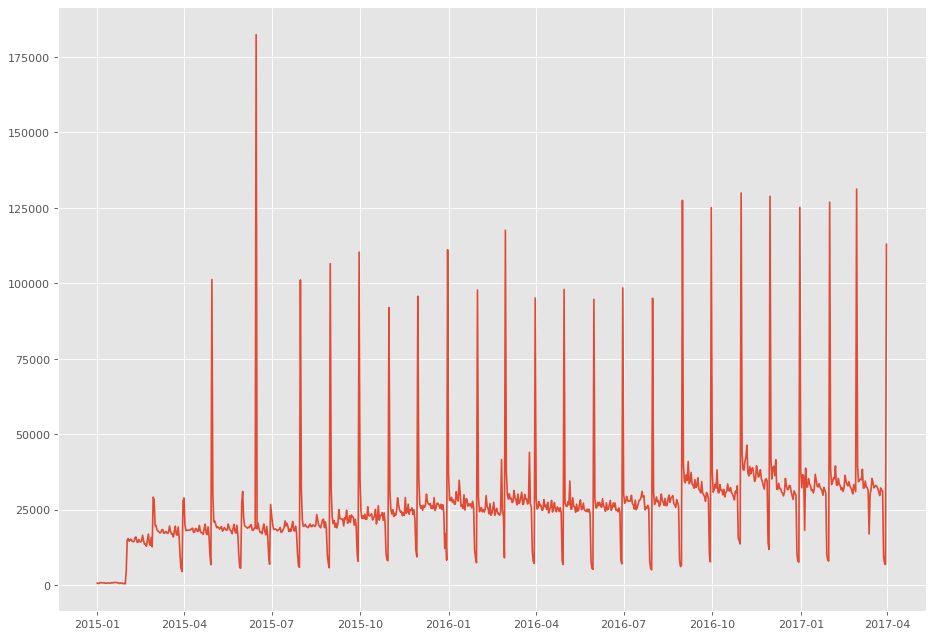

In [112]:
plt.figure(figsize=(14, 10), dpi=80)
plt.plot(transactions.groupby(['membership_expire_date'])['msno'].count())
plt.show()


In [113]:
(transactions.groupby(['is_cancel'])['msno'].count() / transactions.shape[0]).sort_values(ascending=False).round(2)



is_cancel
0    0.96
1    0.04
Name: msno, dtype: float64

Now let's combine all 3 tables in one, to have all needed data in one dataframe.

In [6]:
transactions = transactions.merge(train, how='left', on='msno')


In [115]:
transactions['is_churn'].isnull().sum()


5664598

In [116]:
transactions.head()


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-09-30,2015-11-01,0,0.0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,2015-09-30,2015-10-31,0,0.0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,2015-09-30,2016-04-27,0,NaN
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,2015-09-30,2015-11-28,0,NaN
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,2015-09-30,2015-11-21,0,0.0


In [117]:
transactions.shape


(21547746, 10)

Let's remove customers, in case we didn't find churn data for them.

In [7]:
transactions = transactions.loc[transactions['is_churn'].isnull() == False,:]

transactions.shape

(15883148, 10)

In [120]:
transactions.head()


,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,is_churn
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,2015-09-30,2015-11-01,0,0.0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,2015-09-30,2015-10-31,0,0.0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,2015-09-30,2015-11-21,0,0.0
5,KN7I82kjY0Tn76Ny95ncqBUVbO7b8AXrOPqZutKpxIM=,21,30,149,149,1,2015-09-30,2015-11-07,0,0.0
6,m5ptKif9BjdUghHXXomSezy5ohJiHm85PE13f/3kQaw=,39,30,149,149,1,2015-09-30,2015-11-28,0,0.0


In [8]:
transactions = transactions.merge(members, how='left', on='msno')


In [122]:
transactions['registration_init_time'].isnull().sum()


1600752

Similar to churn data, let's remove transaction without information in members table.

In [9]:
transactions = transactions.loc[transactions['registration_init_time'].isnull() == False,:]

transactions.shape

(14282396, 15)

Add some attributes to the dataset.

In [10]:
transactions['registration_init_month'] = \
    transactions['registration_init_time'].dt.strftime('%Y-%m-01').astype(np.datetime64)

transactions['transaction_month'] = \
    transactions['transaction_date'].dt.strftime('%Y-%m-01').astype(np.datetime64)

transactions['next_transaction_date'] = \
    (transactions.sort_values(by=['msno','transaction_date'], ascending=True)
                 .groupby(['msno'])['transaction_date']
                 .shift(-1)
    )


transactions['days_between_transactions'] = \
    (transactions['next_transaction_date'] - transactions['transaction_date']).dt.days




For some reason sometimes we have several transactions for a user per day.

In [14]:
transactions = transactions.loc[transactions['days_between_transactions'] != 0, :]

transactions.shape


(14098937, 19)

Let's try an exersice to estimate churn probability purerly based on recency (how many days we didn't see a customer). To do that we will choose a particular day (say 2016-12-31) and all the customers who made a purchase on this day (cohort). Then for each further day we will plot the proportion of churned customers out of this cohort customers who didn't make a purchase yet.
In other word such plot will show us an error of churn definition based on how many days we didn't see the customer. For example, what would be our average False Positive rate if we define churn as 45 days of inactivity?

For this dataset it looks like 30 days of customer absence is a perfect value to mark such customer as churned. In this particular case it is due the nature of dataset (we have all active customers who did purchases in March 2017, instead of all customers who did purchases any time). Anyhow, this type of graph could be a useful tool to explore your customers.


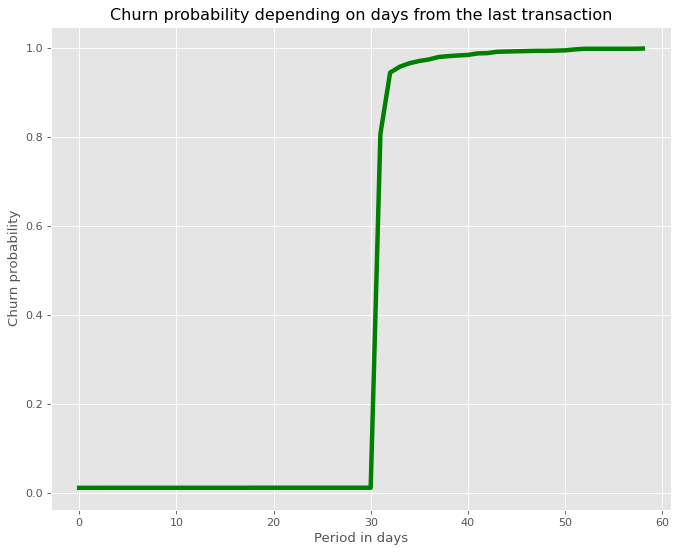

In [75]:

plt.figure(figsize=(10, 8), dpi=80)
    
share = [] 
for idx in range(1, 60):
    
    cohort_size = transactions.loc[transactions['transaction_date'] == '2016-12-31','msno'].shape[0]
    cohort_size_correction = transactions.loc[(transactions['transaction_date'] == '2016-12-31') & 
                                              (transactions['days_between_transactions'] < idx),'msno'].shape[0]
    churned_on_this_transaction = transactions.loc[(transactions['transaction_date'] == '2016-12-31') & 
                                                   (transactions['days_between_transactions'].isnull()),'msno'].shape[0]
    share.append(round(churned_on_this_transaction / (cohort_size - cohort_size_correction), 4))

plt.plot(share, linewidth=4, color='green')    

plt.title('Churn probability depending on days from the last transaction')
plt.xlabel('Period in days')
plt.ylabel('Churn probability')
plt.show()



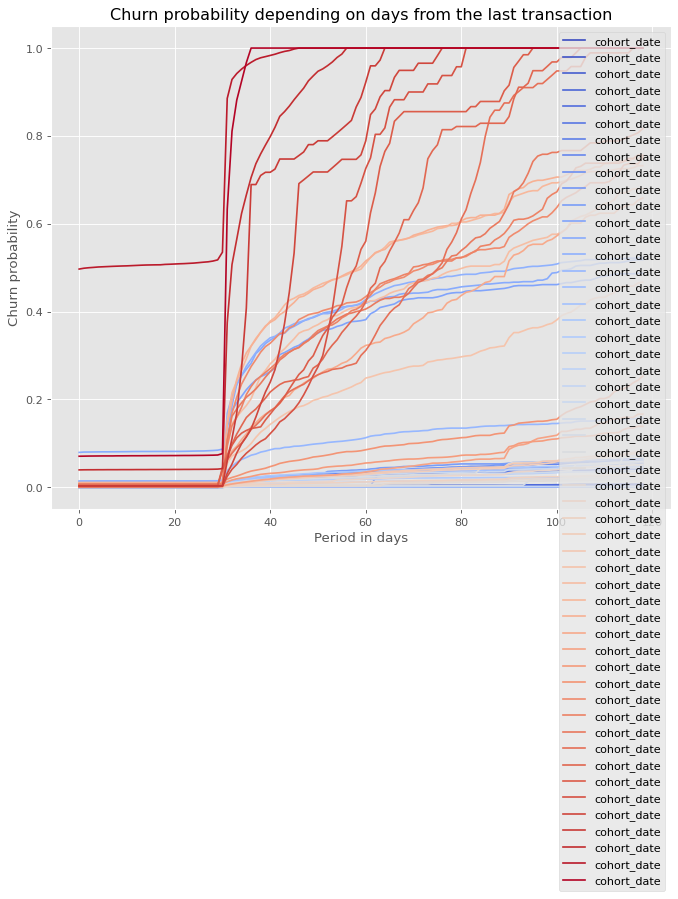

In [72]:

# plt.figure(figsize=(10, 8), dpi=80)
# from matplotlib import rcParams, cycler




# start = datetime.datetime.strptime("2015-09-01", "%Y-%m-%d")
# end = datetime.datetime.strptime("2017-02-01", "%Y-%m-%d")
# dates_list = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days, 10)]

# cmap = plt.cm.coolwarm
# rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, len(dates_list))))

# for cohort_date in dates_list:

#     # cohort_date = '2017-01-31'

#     share = [] 
#     for idx in range(1, 120):

#         cohort_size = transactions.loc[transactions['transaction_date'] == cohort_date,'msno'].shape[0]
#         cohort_size_correction = transactions.loc[(transactions['transaction_date'] == cohort_date) & 
#                                                   (transactions['days_between_transactions'] < idx),'msno'].shape[0]
#         churned_on_this_transaction = transactions.loc[(transactions['transaction_date'] == cohort_date) & 
#                                                        (transactions['days_between_transactions'].isnull()),'msno'].shape[0]
#         share.append(round(churned_on_this_transaction / (cohort_size - cohort_size_correction), 4))

#     plt.plot(share, label='cohort_date')    

# plt.title('Churn probability depending on days from the last transaction')
# plt.xlabel('Period in days')
# plt.ylabel('Churn probability')
# plt.legend()
# plt.show()




# Pareto NBD

Now, let's start actual churn modelling with our first type of model -- Pareto NBD.

We will use a great library with implementation of such models called [lifetimes](https://lifetimes.readthedocs.io/en/latest/).

To fit such statistical model we need only 3 features:
- Number of orders.
- Tenure (the difference between current date and first transaction date).
- Recency (the difference between the last and the first transaction dates). That's a bit unusual, because commonly by recency we mean current date minus last transaction date, but let's keep to the library terminology.


In [15]:
customers = \
    transactions.groupby(['msno'])['transaction_month'].agg(orders='count', 
                                                           first_transaction_month=min, 
                                                           last_transaction_month=max).reset_index()

customers['orders'] = customers['orders'] - 1
customers['tenure'] = (pd.to_datetime('2017-03-01') - customers['first_transaction_month']).dt.days // 30
customers['recency'] = (customers['last_transaction_month'] - customers['first_transaction_month']).dt.days // 30


customers = customers.merge(transactions.groupby(['msno'])['is_churn'].min().reset_index(), how='inner', on=['msno'])


In [116]:
customers.head()


,msno,orders,first_transaction_month,last_transaction_month,tenure,recency,is_churn
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,3,2016-11-01,2017-02-01,4,3,0.0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,18,2015-01-01,2017-01-01,26,24,0.0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,25,2015-01-01,2017-02-01,26,25,0.0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,11,2016-03-01,2017-02-01,12,11,0.0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,18,2015-01-01,2017-01-01,26,24,0.0


Firstly let's take a look on a capacity of statistical models to provide exploratory insights.

In [19]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.3)
bgf.fit(customers['orders'], customers['recency'], customers['tenure'])
print(bgf)

bgf.summary


<lifetimes.BetaGeoFitter: fitted with 877161 subjects, a: 0.00, alpha: 1.08, b: 0.03, r: 0.90>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.898965,0.000911,0.897179,0.900751
alpha,1.076222,0.001670,1.072949,1.079496
a,0.000014,0.000001,0.000011,0.000016
b,0.027189,0.001066,0.025099,0.029278


Once we have fitted model, we can have the estimation of number of future purchases for the next 1 unit of time (in our case it's one month). We can see that the most valuable customers are the oldest ones (high receny), who make a lot of purchases (high frequency). Which is kind of obvious result, but the valuable thing is, now we have it quantified. For example, we can see that on the early stages one purchase per month does not guarantee us that customer will continue to buy, whereas on the later stages (1-2 years old customers) are still a valuable customers even if the buy once per 2 months.


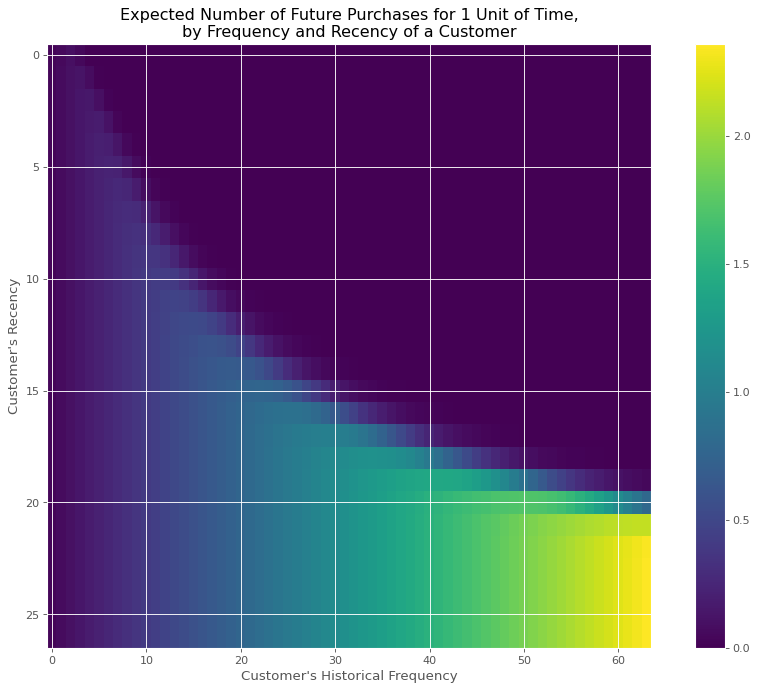

In [118]:
from lifetimes.plotting import plot_frequency_recency_matrix


plt.figure(figsize=(14, 10), dpi=80)
plot_frequency_recency_matrix(bgf)
plt.show()


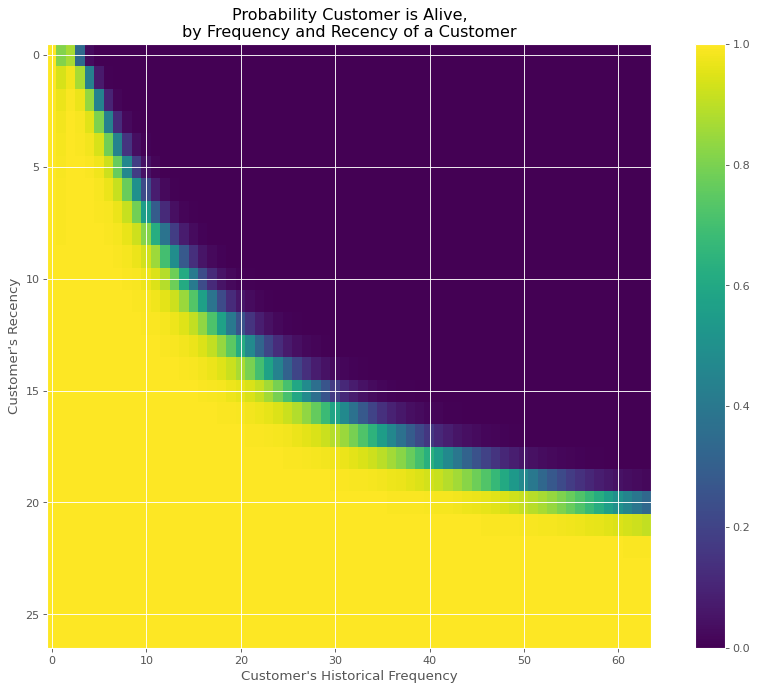

In [119]:
from lifetimes.plotting import plot_probability_alive_matrix

plt.figure(figsize=(14, 10), dpi=80)
plot_probability_alive_matrix(bgf)
plt.show()


In [120]:
t = 1
customers['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, customers['orders'], customers['recency'], customers['tenure'])
customers.sort_values(by='predicted_purchases').tail(5)


,msno,orders,first_transaction_month,last_transaction_month,tenure,recency,is_churn,predicted_purchases
207036,D6PQC4MEemxjgPEvhygBJIO//5ZtsHli+zPoqmUKRX0=,6,2017-01-01,2017-02-01,1,1,0.0,3.322824
321509,LS+84gO0czg6XOUIFA39h5hiPpQHLk61Ebf0XkenfTg=,6,2017-01-01,2017-02-01,1,1,0.0,3.322824
332407,MEqP6idpSJNOHWWYc2L1RbICc/afp3J47/npcY7RWY8=,6,2017-01-01,2017-02-01,1,1,0.0,3.322824
363027,OUgtb99y/e2A+vKWRY6dSgYNBK1ts4Gv+N2wpTt9yYc=,6,2017-01-01,2017-02-01,1,1,0.0,3.322824
614269,goBOEk6NwdsHlWNgH0uCEkYUnSM+0lWj16JzWrJizB4=,6,2017-01-01,2017-02-01,1,1,0.0,3.322824


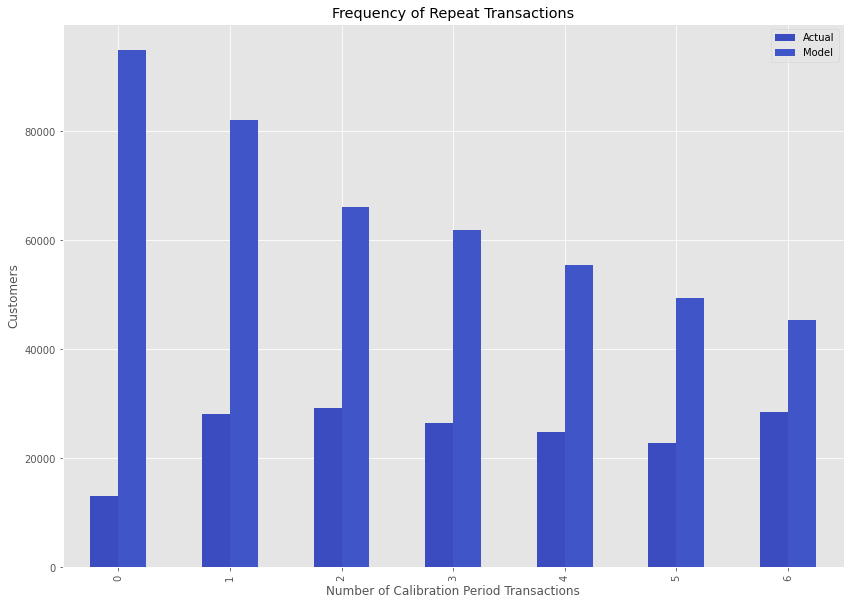

In [121]:
# from lifetimes.plotting import plot_period_transactions

# plot_period_transactions(bgf,figsize=(14, 10))
# plt.show()


In [ ]:
# from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

# bgf = BetaGeoFitter(penalizer_coef=0.0)
# bgf.fit(customers['frequency_cal'], df['recency_cal'], df['T_cal'])
# plot_calibration_purchases_vs_holdout_purchases(bgf, df, figsize=(14, 10))
# plt.show()


In [16]:
customers['is_alive'] = 1
customers.loc[customers['is_churn'] == 1,'is_alive'] = 0


Now let's calculate metrics to evaluate model's prediction performance.
We will use 4 measures:
- ROC AUC. This is the most commonly used performance metric for binary classification. The value 0.5 means prediction is absolutely random, 1.0 means an ideal prediction.
- Log Loss. This metric allows us to evaluate not only the correctnes of a binary prediction (churn or not), but the proximity of probability estimation. In other words, if the actual churn probability for some customer is 0.8 and our model tells that it's 0.3, from ROC AUC perspective it can be still a perfect model (it doesn't care how far we are from the actual probability untill we have a good threshold value to separate classes), but from Log Loss perspective it is a bad model. The lower value the better, ideal value is 0 without top boundary. A good way to understand whether the value is good or not is to compare it with random guesses.
- ROC and Precision-Recall curves. Similar to ROC AUC, but provide a visual sense of the model quality.
- Calibration curve. This curve shows us how far our probability estimations from actual churn probabilities.



As a common machine learning practice, let's split our dataset on train and test parts.

In [126]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, mean_squared_error, roc_curve, precision_recall_curve, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(customers.loc[:, ['orders', 'recency', 'tenure']],
                                                    customers['is_alive'].values,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=100,
                                                    stratify=customers['is_alive'].values
                                                   )


This time for the prediction purposes we will use Pareto/NBD model, which is more accurate, but takes more time to train.

In [128]:
from lifetimes import ParetoNBDFitter

pNBD = ParetoNBDFitter(penalizer_coef=0.3)
pNBD.fit(X_train['orders'], X_train['recency'], X_train['tenure'])
print(pNBD)



<lifetimes.ParetoNBDFitter: fitted with 701728 subjects, alpha: 140.26, beta: 0.02, r: 119.70, s: 0.00>


For test part let's predict churn probability.

In [130]:
X_test['prob_alive_pNBD'] = -1
X_test['prob_alive_pNBD'] = pNBD.conditional_probability_alive(X_test['orders'], X_test['recency'], X_test['tenure'])
X_test['prob_churn_pNBD'] = 1 - X_test['prob_alive_pNBD']

y_test_churn = 1 - y_test
y_train_churn = 1 - y_train


The results are quite good, especially for the fact that we used only 3 features. ROC AUC is 0.77, which is definitely not random. But as we can see Log Loss is pretty high, wihch means that this model have difficulties with churn probability estimation. But such estimation is crucial for LTV prediction.


Test ROC AUC: 0.774217
Test Log Loss: 0.454669
Baseline (random) Log Loss: 0.242448
[[163252    650]
 [ 10190   1341]]


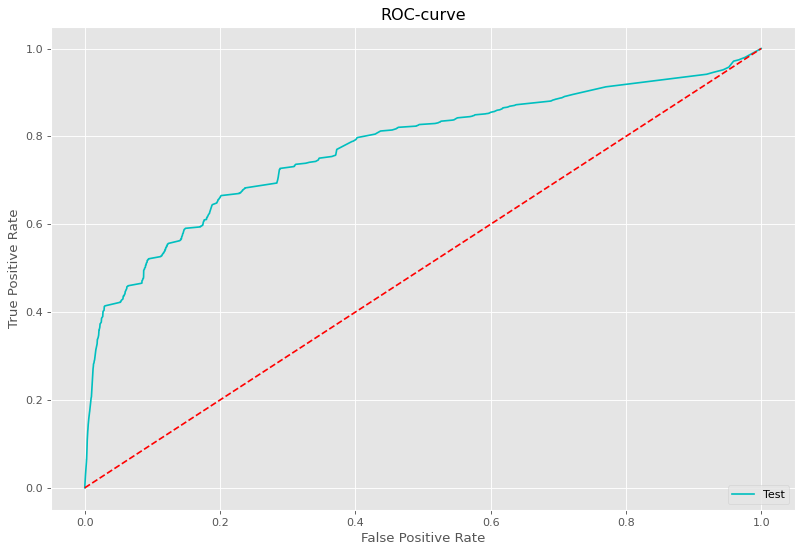

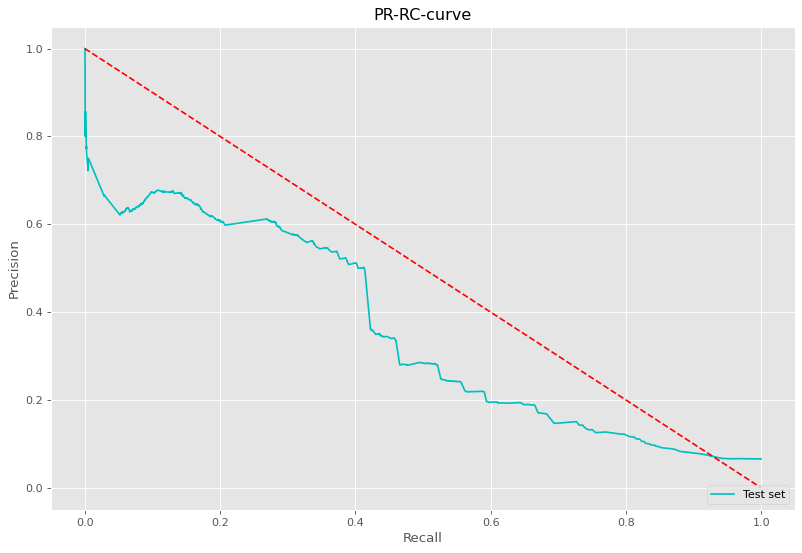

In [147]:
roc_auc_test = roc_auc_score(y_test_churn, X_test['prob_churn_pNBD'])
log_loss_test = log_loss(y_test_churn, X_test['prob_churn_pNBD'])
baseline_log_loss = log_loss(y_test_churn, [sum(y_train_churn) / len(y_train_churn)] * len(y_test_churn))
print('Test ROC AUC: {}\nTest Log Loss: {}\nBaseline (random) Log Loss: {}'.format(round(roc_auc_test,6), round(log_loss_test,6), round(baseline_log_loss,6)))
print(confusion_matrix(y_test_churn, (X_test['prob_churn_pNBD'] > 0.5) * 1))



plt.figure(figsize=(12, 8), dpi=80)
fpr, tpr, threshold = roc_curve(y_test_churn, X_test['prob_churn_pNBD'])
plt.plot(fpr, tpr, 'c', label = 'Test')
plt.title('ROC-curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
precision, recall, threshold = precision_recall_curve(y_test_churn, X_test['prob_churn_pNBD'])
plt.plot(recall, precision, 'c', label = 'Test set')
plt.title('PR-RC-curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'r--')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

From the calibration curve we can see that model assigns to low probabilities. For example customers with actual churn probability of 0.6 have 0.2 prediction probability on average.

In [149]:
X_test['churn_batch'] = round(X_test['prob_churn_pNBD'], 1)
X_test['is_churn'] = y_test_churn

X_test.groupby(['churn_batch'])['is_churn'].mean()


churn_batch
0.0    0.055768
0.1    0.531624
0.2    0.649746
0.3    0.680982
0.4    0.529412
0.5    0.826087
0.6    0.521739
0.7    0.644444
0.8    0.742138
0.9    0.805085
1.0    0.634425
Name: is_churn, dtype: float64

In [151]:
X_test.groupby(['churn_batch'])['is_churn'].count()


churn_batch
0.0    172464
0.1       585
0.2       197
0.3       163
0.4        17
0.5        23
0.6        23
0.7       135
0.8       159
0.9       354
1.0      1313
Name: is_churn, dtype: int64

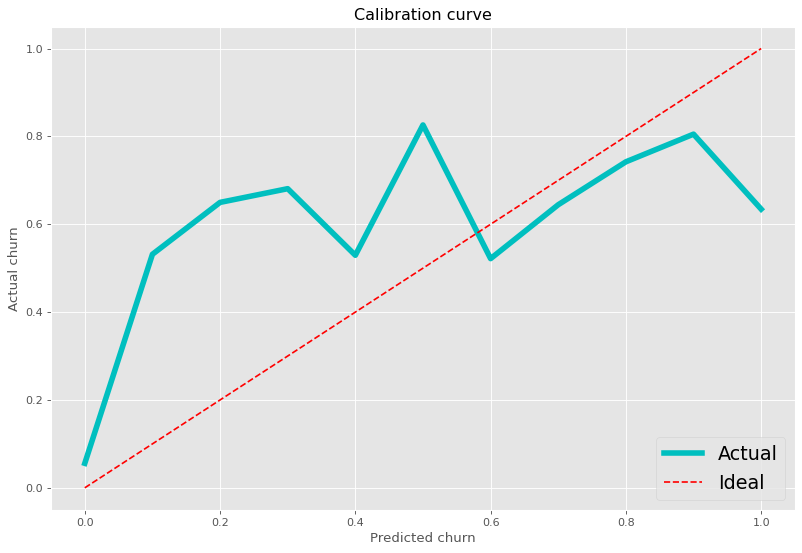

In [150]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(X_test.groupby(['churn_batch'])['is_churn'].mean(), 'c', label='Actual', linewidth=5)
plt.plot([0, 1], [0, 1],'r--', label='Ideal')
plt.legend(loc = 'lower right', fontsize='xx-large')
plt.title('Calibration curve')
plt.ylabel('Actual churn')
plt.xlabel('Predicted churn')
plt.show()


# Survavial analysis

The second approach is to use survavial analysis, which is good for contractual set ups.

There is another python library of the same author called [LifeLines](https://lifelines.readthedocs.io/en/latest/).


In [18]:
from sklearn.metrics import brier_score_loss

import lifelines

Again, let's see how such type of analysis helps us on exploration phase. We can plot Kaplan-Meier survavial curves to see how does survive (1 - churn) probability depends on customer tenure.


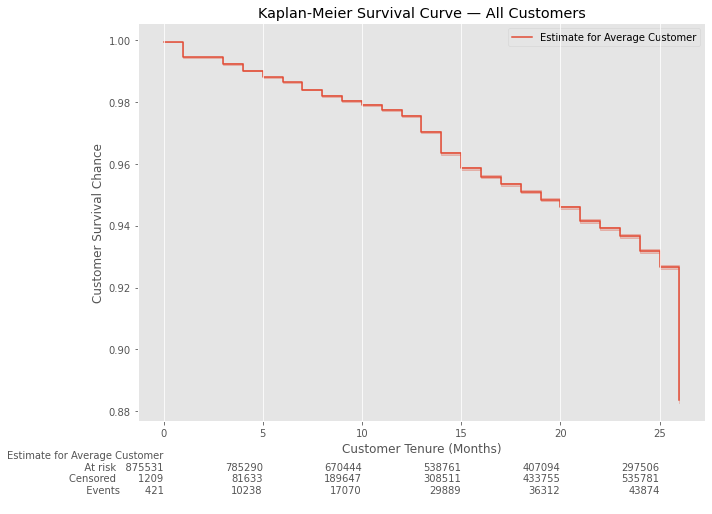

In [19]:
from sklearn.metrics import brier_score_loss

import lifelines

kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations = customers['tenure'], event_observed = customers['is_churn'], 
        label = 'Estimate for Average Customer')

fig, ax = plt.subplots(figsize = (10,7))
kmf.plot(at_risk_counts = True, ax=ax)
ax.set_title('Kaplan-Meier Survival Curve — All Customers')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
ax.grid()



The valuable thing is such curves give us an ability to compare different groups of customers, thus evaluate whether some feature affects churn probability or not.



In [20]:
def bd_chunk(bd):
    if pd.isnull(bd):
        x = np.nan
    elif bd < 30:
        x = 1
    elif bd < 50:
        x = 2
    elif bd < 70:
        x = 3
    else:
        x = 4
    return x
        

transactions['bd_chunk'] = transactions['bd'].apply(bd_chunk)



In [36]:
transactions.groupby(['bd_chunk'])['msno'].count()


bd_chunk
1.0    3540814
2.0    2899470
3.0     274918
4.0       9237
Name: msno, dtype: int64

In [22]:
transactions.sort_values(by=['msno', 'transaction_date'], ascending=[True, False], inplace=True)


customers = \
    customers.merge(
        transactions.groupby(['msno'])[['is_auto_renew', 
                                        'payment_method_id', 
                                        'city', 
                                        'bd_chunk', 
                                        'gender', 
                                        'registered_via']]
                    .first()
                    .reset_index(), 
    how='left', 
    on=['msno']
)


In [48]:
customers.head()


,msno,orders,first_transaction_month,last_transaction_month,tenure,recency,is_churn,is_auto_renew,payment_method_id,city,bd_chunk,gender,registered_via
0,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,3,2016-11-01,2017-02-01,4,3,0.0,1,41,1.0,NaN,NaN,7.0
1,+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,18,2015-01-01,2017-01-01,26,24,0.0,1,39,15.0,1.0,male,9.0
2,+++snpr7pmobhLKUgSHTv/mpkqgBT0tQJ0zQj6qKrqc=,25,2015-01-01,2017-02-01,26,25,0.0,1,41,1.0,NaN,NaN,7.0
3,++/9R3sX37CjxbY/AaGvbwr3QkwElKBCtSvVzhCBDOk=,11,2016-03-01,2017-02-01,12,11,0.0,1,41,18.0,1.0,male,7.0
4,++/UDNo9DLrxT8QVGiDi1OnWfczAdEwThaVyD0fXO50=,18,2015-01-01,2017-01-01,26,24,0.0,1,39,22.0,2.0,male,9.0


For example, we can see that auto_renew is dramatically reduce churn chances.

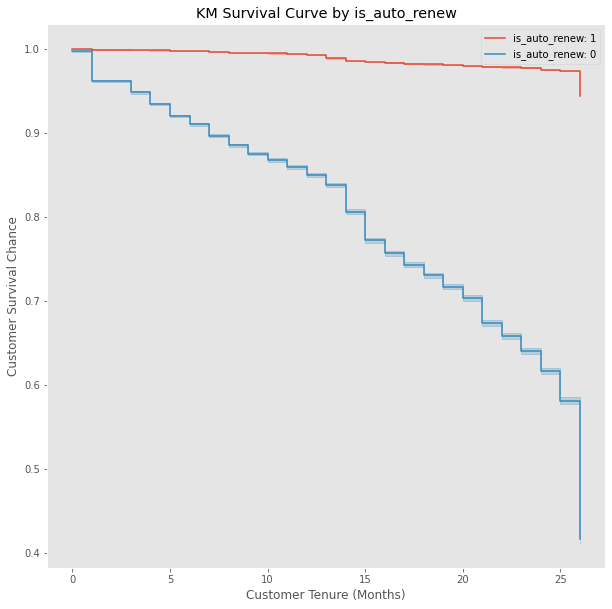

In [62]:
feature = 'is_auto_renew'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
for value in customers[feature].unique():
    kmf_feature = lifelines.KaplanMeierFitter()
    ax = kmf_feature.fit(durations = customers.loc[customers[feature] == value, 'tenure'], 
                         event_observed = customers.loc[customers[feature] == value, 'is_churn'],
                         label = '{}: {}'.format(feature, str(value))).plot(ax = ax)

ax.set_title('KM Survival Curve by {}'.format(feature))
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()



Also, we can see that there are 3 groups of payment methods which affect churn probability significantly. For the business it means that there is a lot of value in convincing customers to use one payment method over the other.

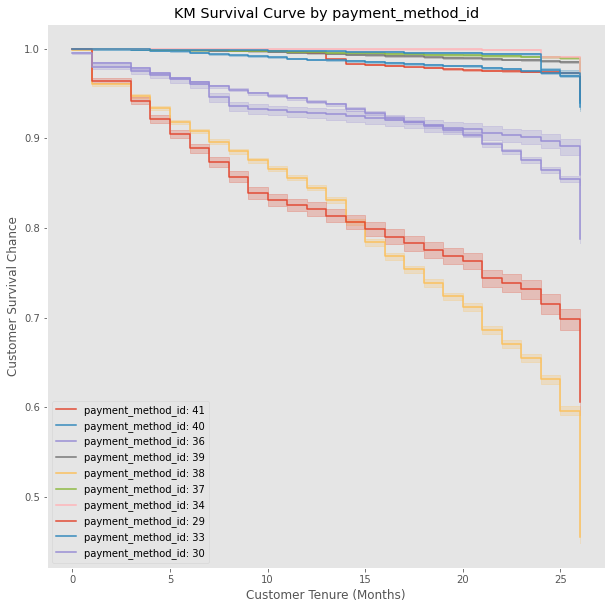

In [71]:
feature = 'payment_method_id'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
for value in customers.groupby(feature)['msno'].count().sort_values(ascending=False).index[0:10]:
    kmf_feature = lifelines.KaplanMeierFitter()
    ax = kmf_feature.fit(durations = customers.loc[customers[feature] == value, 'tenure'], 
                         event_observed = customers.loc[customers[feature] == value, 'is_churn'],
                         label = '{}: {}'.format(feature, str(value))).plot(ax = ax)

ax.set_title('KM Survival Curve by {}'.format(feature))
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()




Cities are more or less equall in terms of churn probabilities.

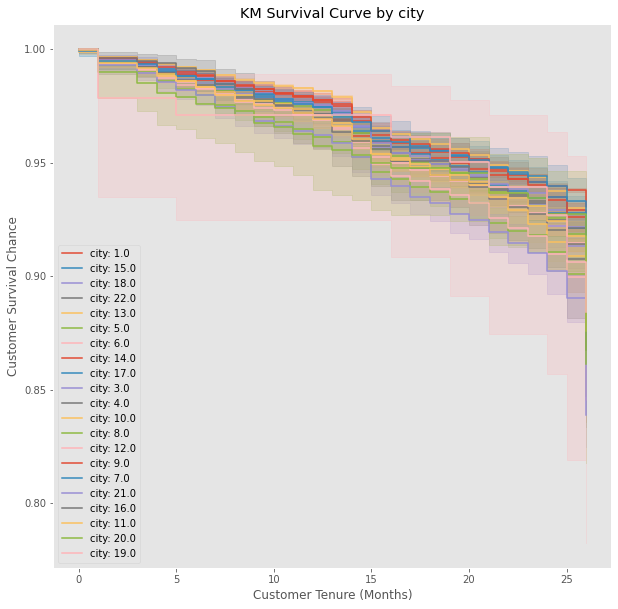

In [72]:
feature = 'city'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
for value in customers[feature].unique():
    kmf_feature = lifelines.KaplanMeierFitter()
    ax = kmf_feature.fit(durations = customers.loc[customers[feature] == value, 'tenure'], 
                         event_observed = customers.loc[customers[feature] == value, 'is_churn'],
                         label = '{}: {}'.format(feature, str(value))).plot(ax = ax)

ax.set_title('KM Survival Curve by {}'.format(feature))
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()




From the age perspective the yongest and the oldest customers are in high risk of churn.

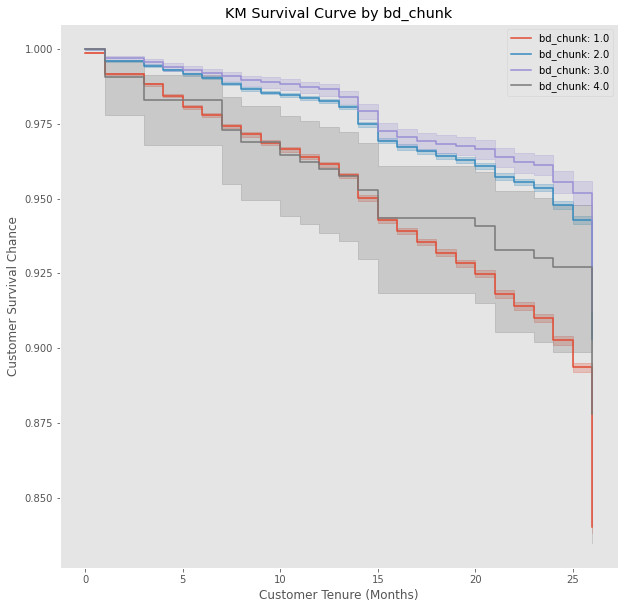

In [76]:
feature = 'bd_chunk'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
for value in customers.dropna(subset=[feature])[feature].unique():
    kmf_feature = lifelines.KaplanMeierFitter()
    ax = kmf_feature.fit(durations = customers.dropna(subset=[feature]).loc[customers[feature] == value, 'tenure'], 
                         event_observed = customers.dropna(subset=[feature]).loc[customers[feature] == value, 'is_churn'],
                         label = '{}: {}'.format(feature, str(value))).plot(ax = ax)

ax.set_title('KM Survival Curve by {}'.format(feature))
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()




But genders are the same.

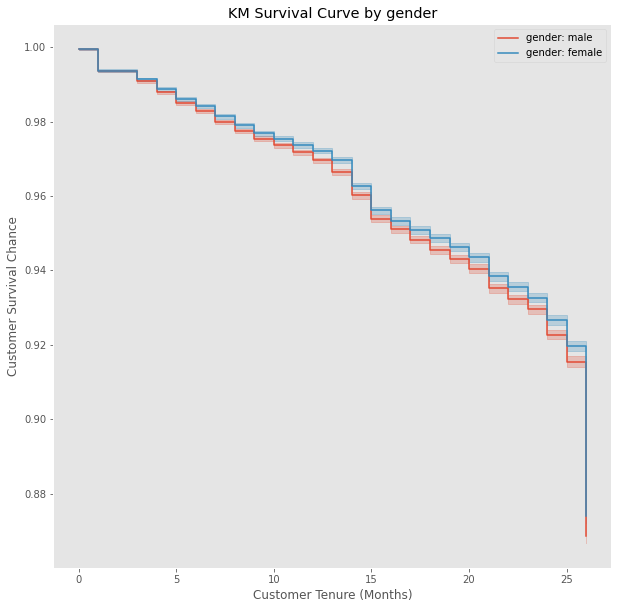

In [77]:
feature = 'gender'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
for value in customers.dropna(subset=[feature])[feature].unique():
    kmf_feature = lifelines.KaplanMeierFitter()
    ax = kmf_feature.fit(durations = customers.dropna(subset=[feature]).loc[customers[feature] == value, 'tenure'], 
                         event_observed = customers.dropna(subset=[feature]).loc[customers[feature] == value, 'is_churn'],
                         label = '{}: {}'.format(feature, str(value))).plot(ax = ax)

ax.set_title('KM Survival Curve by {}'.format(feature))
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()





Also the channel of attraction matters.

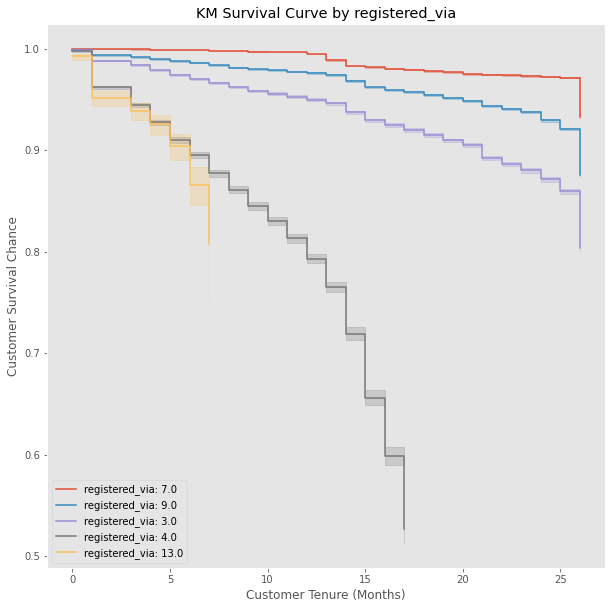

In [78]:
feature = 'registered_via'

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
for value in customers.dropna(subset=[feature])[feature].unique():
    kmf_feature = lifelines.KaplanMeierFitter()
    ax = kmf_feature.fit(durations = customers.dropna(subset=[feature]).loc[customers[feature] == value, 'tenure'], 
                         event_observed = customers.dropna(subset=[feature]).loc[customers[feature] == value, 'is_churn'],
                         label = '{}: {}'.format(feature, str(value))).plot(ax = ax)

ax.set_title('KM Survival Curve by {}'.format(feature))
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()



In [86]:
customers.isnull().sum()


msno                            0
orders                          0
first_transaction_month         0
last_transaction_month          0
tenure                          0
recency                         0
is_churn                        0
is_auto_renew                   0
payment_method_id               0
city                            0
bd_chunk                   488136
gender                     485469
registered_via                  0
dtype: int64

In [87]:
customers.groupby(['is_auto_renew'])['msno'].count()


is_auto_renew
0    109730
1    767431
Name: msno, dtype: int64

In [23]:
def payment_method_chunk(val):
    if pd.isnull(val):
        x = np.nan
    elif val in [41, 40, 39, 37, 34, 33]:
        x = 1
    elif val in [30, 36]:
        x = 2
    elif val in [29, 38]:
        x = 3
    else:
        x = 4
    return x
        

customers['payment_method_chunk'] = customers['payment_method_id'].apply(payment_method_chunk)



Now let's train our survavial model using payment method and tenure features.

In [24]:
customers = pd.get_dummies(customers, columns = ['is_auto_renew', 'payment_method_chunk'], drop_first = False)
customers.drop(columns = ['is_auto_renew_1', 'payment_method_chunk_1'], inplace = True)


In [48]:
data = customers[['payment_method_chunk_2', 'payment_method_chunk_3', 'payment_method_chunk_4', 'tenure', 'is_churn']]


X_train, X_test, y_train, y_test = train_test_split(data.loc[:, ['payment_method_chunk_2', 'payment_method_chunk_3', 'payment_method_chunk_4', 'tenure']],
                                                    data['is_churn'].values,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=100,
                                                    stratify=data['is_churn'].values
                                                   )

data_train = pd.concat([X_train, pd.Series(y_train, index=X_train.index, name='is_churn')], axis=1)
data_test = pd.concat([X_test, pd.Series(y_test, index=X_test.index, name='is_churn')], axis=1)


In [49]:

cph = lifelines.CoxPHFitter()
cph.fit(data_train, duration_col = 'tenure', event_col = 'is_churn')

cph.print_summary(model = 'base model', decimals = 3, columns = ['coef', 'exp(coef)', 'p']) 

avg_score = np.mean(lifelines.utils.k_fold_cross_validation(cph, data_test, 'tenure',
                                'is_churn', k = 3,
                                scoring_method = 'concordance_index'))
print('The average Concordance Score across 3 folds is: {:.3f}'.format(avg_score))


<lifelines.CoxPHFitter: fitted with 701728 total observations, 655604 right-censored observations>
             duration col = 'tenure'
                event col = 'is_churn'
      baseline estimation = breslow
   number of observations = 701728
number of events observed = 46124
   partial log-likelihood = -563377.056
         time fit was run = 2021-06-16 14:22:01 UTC
                    model = base model

---
                         coef  exp(coef)       p
covariate                                       
payment_method_chunk_2  1.615      5.030 <0.0005
payment_method_chunk_3  2.792     16.309 <0.0005
payment_method_chunk_4  2.375     10.748 <0.0005
---
Concordance = 0.786
Partial AIC = 1126760.112
log-likelihood ratio test = 64211.748 on 3 df
-log2(p) of ll-ratio test = inf

The average Concordance Score across 3 folds is: 0.791


In [52]:
probs = 1 - np.array(cph.predict_survival_function(data_test, times = 1).T)


ROC AUC is relitively similar to Pareto/NBD model -- 0.76, but log loss is much better, still 0.31 is too high. Generally it's a good model, but again with issue in evaluating actual churn probabilities.


Test ROC AUC: 0.762221
Test Log Loss: 0.31405
[[163902      0]
 [ 11531      0]]


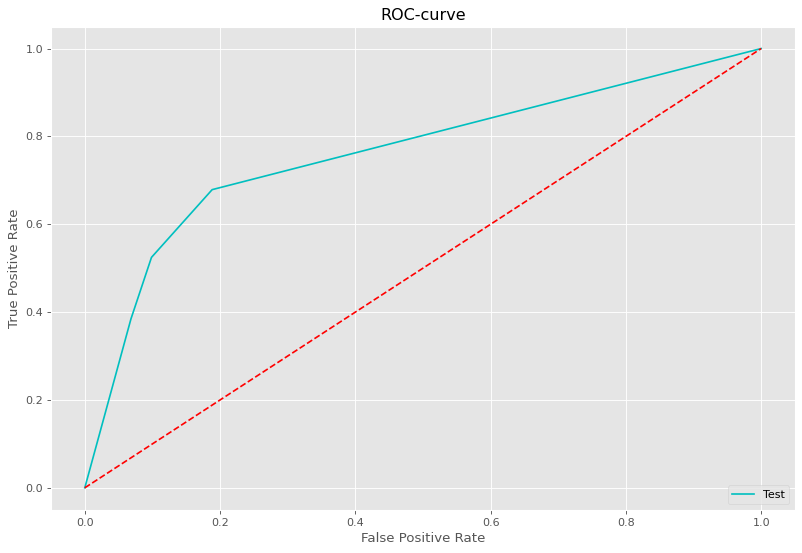

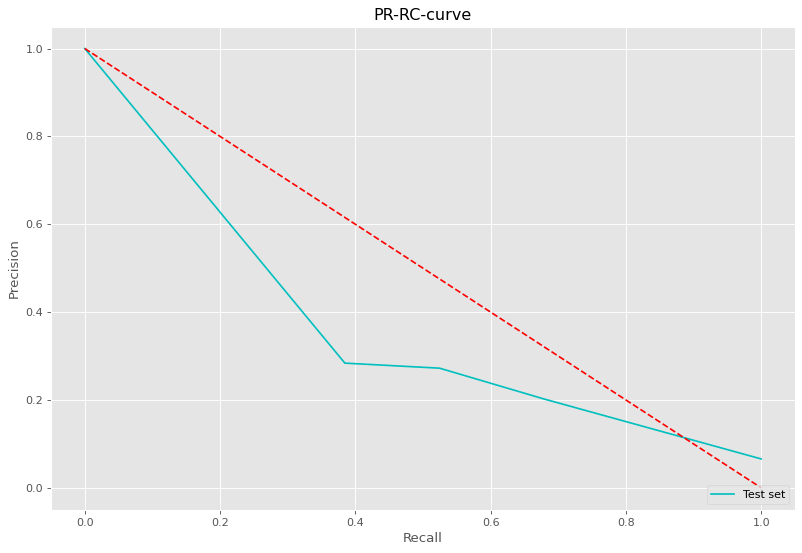

In [54]:
roc_auc_test = roc_auc_score(data_test['is_churn'], probs)
log_loss_test = log_loss(data_test['is_churn'], probs)
# baseline_log_loss = log_loss(y_test_churn, [sum(y_train_churn) / len(y_train_churn)] * len(y_test_churn))
print('Test ROC AUC: {}\nTest Log Loss: {}'.format(round(roc_auc_test,6), round(log_loss_test,6)))
print(confusion_matrix(data_test['is_churn'], (probs > 0.5) * 1))



plt.figure(figsize=(12, 8), dpi=80)
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, 'c', label = 'Test')
plt.title('ROC-curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
precision, recall, threshold = precision_recall_curve(y_test, probs)
plt.plot(recall, precision, 'c', label = 'Test set')
plt.title('PR-RC-curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'r--')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [26]:
from sklearn.calibration import calibration_curve 

In [1]:

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2) 

ax1.plot([0, 1], [0, 1], ls = '--', label = 'Perfectly calibrated') 

probs = 1 - np.array(cph.predict_survival_function(data_test, times = 12).T)
actual = data_test['is_churn'] 

fraction_of_positives, mean_predicted_value = calibration_curve(actual, probs, n_bins = 10, strategy = 'quantile') 
ax1.plot(mean_predicted_value, fraction_of_positives, marker = 's', ls = '-', label='CoxPH') 
ax1.set_ylabel("Actual fraction of positives") 
ax1.set_xlabel("Predicted churn probability")
ax1.set_ylim([-0.05, 1.05]) 
ax1.legend(loc="lower right") 
ax1.set_title('Calibration plots (reliability curve) for the 12th month');


NameError: name 'plt' is not defined

# 3. Machine learning approach

Now let's beat our problem with a multi-purpose hammer -- machine learning.

Let's use Random Forest with the same features as we used in Survavial model. 


In [55]:
from sklearn.ensemble import RandomForestClassifier


In [59]:

cols = ['payment_method_chunk_2', 'payment_method_chunk_3', 'payment_method_chunk_4', 'tenure']


In [56]:
model = RandomForestClassifier(n_estimators = 1000, max_depth=5)

model.fit(X_train,y_train)


RandomForestClassifier(max_depth=5, n_estimators=1000)

Even with the same features it shows much better performance: ROC AUC 0.80, with Log Loss 0.20. Finally we have model with better churn probability estimation than random guessing.


In [57]:
threshold = 0.5

result = (model.predict_proba(X_test)[:,1] > threshold) * 1
print(confusion_matrix(y_test, result))
print(classification_report(y_test, result))

roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
log_loss_test = log_loss(y_test, model.predict_proba(X_test)[:,1])
baseline_log_loss = log_loss(y_test, [sum(y_train) / len(y_train)] * len(y_test))
print('Test Overall      ROC AUC: {}, Log Loss: {}, Baseline Log Loss: {}'.format(round(roc_auc_test,6),
                                                                     round(log_loss_test,6),
                                                                     round(baseline_log_loss,6)
                                                                    ))


X_train_temp = X_train.copy()
X_train_temp['is_churn'] = y_train
X_train_temp = X_train_temp.loc[(X_train_temp['frequency'] == 1) & (X_train_temp['subs_orders'] == 0), :]
X_test_temp = X_test.copy()
X_test_temp['is_churn'] = y_test
X_test_temp = X_test_temp.loc[(X_test_temp['frequency'] == 1) & (X_test_temp['subs_orders'] == 0), :]

roc_auc_test = roc_auc_score(X_test_temp['is_churn'], model.predict_proba(X_test_temp[cols])[:,1])
log_loss_test = log_loss(X_test_temp['is_churn'], model.predict_proba(X_test_temp[cols])[:,1])
baseline_log_loss = log_loss(X_test_temp['is_churn'], [sum(X_train_temp['is_churn']) / X_train_temp.shape[0]] * X_test_temp.shape[0])
print('Test Try n Bounce ROC AUC: {}, Log Loss: {}, Baseline Log Loss: {}'.format(round(roc_auc_test,6),
                                                                     round(log_loss_test,6),
                                                                     round(baseline_log_loss,6)
                                                                    ))

X_train_temp = X_train.copy()
X_train_temp['is_churn'] = y_train
X_train_temp = X_train_temp.loc[(X_train_temp['frequency'] > 1) & (X_train_temp['subs_orders'] == 0), :]
X_test_temp = X_test.copy()
X_test_temp['is_churn'] = y_test
X_test_temp = X_test_temp.loc[(X_test_temp['frequency'] > 1) & (X_test_temp['subs_orders'] == 0), :]

roc_auc_test = roc_auc_score(X_test_temp['is_churn'], model.predict_proba(X_test_temp[cols])[:,1])
log_loss_test = log_loss(X_test_temp['is_churn'], model.predict_proba(X_test_temp[cols])[:,1])
baseline_log_loss = log_loss(X_test_temp['is_churn'], [sum(X_train_temp['is_churn']) / X_train_temp.shape[0]] * X_test_temp.shape[0])
print('Test Irregular    ROC AUC: {}, Log Loss: {}, Baseline Log Loss: {}'.format(round(roc_auc_test,6),
                                                                     round(log_loss_test,6),
                                                                     round(baseline_log_loss,6)
                                                                    ))


X_train_temp = X_train.copy()
X_train_temp['is_churn'] = y_train
X_train_temp = X_train_temp.loc[(X_train_temp['subs_orders'] > 0), :]
X_test_temp = X_test.copy()
X_test_temp['is_churn'] = y_test
X_test_temp = X_test_temp.loc[(X_test_temp['subs_orders'] > 0), :]


roc_auc_test = roc_auc_score(X_test_temp['is_churn'], model.predict_proba(X_test_temp[cols])[:,1])
log_loss_test = log_loss(X_test_temp['is_churn'], model.predict_proba(X_test_temp[cols])[:,1])
baseline_log_loss = log_loss(X_test_temp['is_churn'], [sum(X_train_temp['is_churn']) / X_train_temp.shape[0]] * X_test_temp.shape[0])
print('Test Subscribers  ROC AUC: {}, Log Loss: {}, Baseline Log Loss: {}'.format(round(roc_auc_test,6),
                                                                     round(log_loss_test,6),
                                                                     round(baseline_log_loss,6)
                                                                    ))

[[163479    423]
 [ 11052    479]]
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97    163902
         1.0       0.53      0.04      0.08     11531

    accuracy                           0.93    175433
   macro avg       0.73      0.52      0.52    175433
weighted avg       0.91      0.93      0.91    175433

Test Overall      ROC AUC: 0.805192, Log Loss: 0.195924, Baseline Log Loss: 0.242448


KeyError: 'frequency'

Plus, we can easily see the features importance, which can help us to drive some business decisions.


In [60]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = cols,
                                   columns=['importance']).sort_values('importance',  ascending=False)

feature_importances


,importance
payment_method_chunk_3,0.546152
payment_method_chunk_4,0.200500
tenure,0.199514
payment_method_chunk_2,0.053834


Test ROC AUC: 0.762221
Test Log Loss: 0.31405
[[163902      0]
 [ 11531      0]]


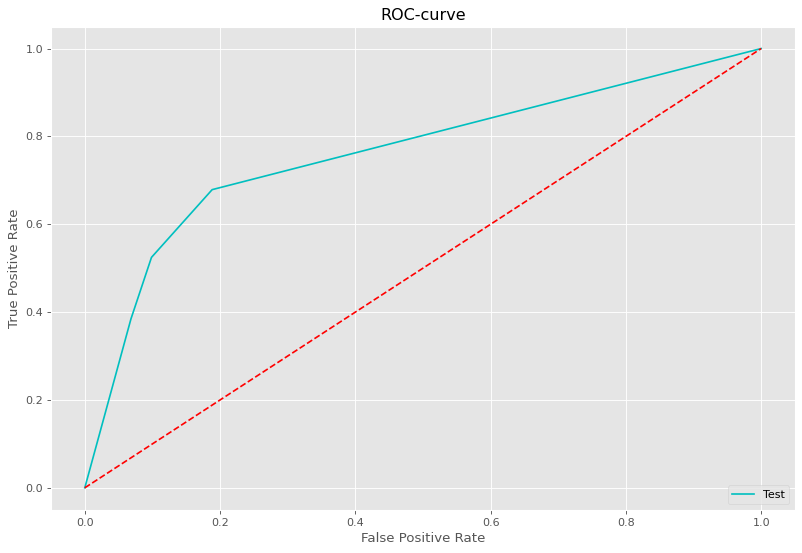

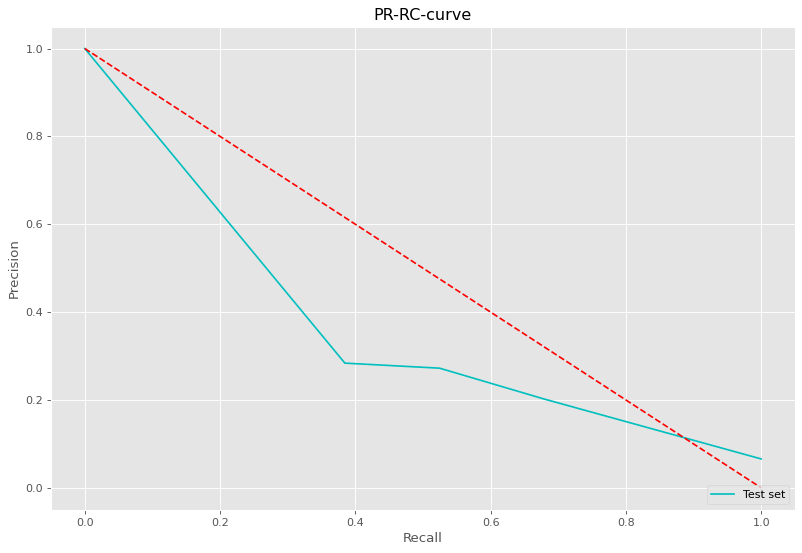

In [61]:
roc_auc_test = roc_auc_score(data_test['is_churn'], probs)
log_loss_test = log_loss(data_test['is_churn'], probs)
# baseline_log_loss = log_loss(y_test_churn, [sum(y_train_churn) / len(y_train_churn)] * len(y_test_churn))
print('Test ROC AUC: {}\nTest Log Loss: {}'.format(round(roc_auc_test,6), round(log_loss_test,6)))
print(confusion_matrix(data_test['is_churn'], (probs > 0.5) * 1))



plt.figure(figsize=(12, 8), dpi=80)
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, 'c', label = 'Test')
plt.title('ROC-curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
precision, recall, threshold = precision_recall_curve(y_test, probs)
plt.plot(recall, precision, 'c', label = 'Test set')
plt.title('PR-RC-curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'r--')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

But what if we use more features, such as number of orders, recency, is_auto_renew?

In [63]:

cols = ['orders', 'recency', 'is_auto_renew_0', 'payment_method_chunk_2', 'payment_method_chunk_3', 'payment_method_chunk_4', 'tenure']

X_train, X_test, y_train, y_test = train_test_split(customers.loc[:, cols],
                                                    customers['is_churn'].values,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=100,
                                                    stratify=customers['is_churn'].values
                                                   )





In [64]:
model = RandomForestClassifier(n_estimators = 1000, max_depth=5)

model.fit(X_train,y_train)


RandomForestClassifier(max_depth=5, n_estimators=1000)

The result is even better -- ROC AUC becomes 0.85, Log Loss 0.17. That's already a good to implement model, which should help us to predict customers churn rates much better than some rule-based models.


Test ROC AUC: 0.848346
Test Log Loss: 0.175858
[[163107    795]
 [  9712   1819]]


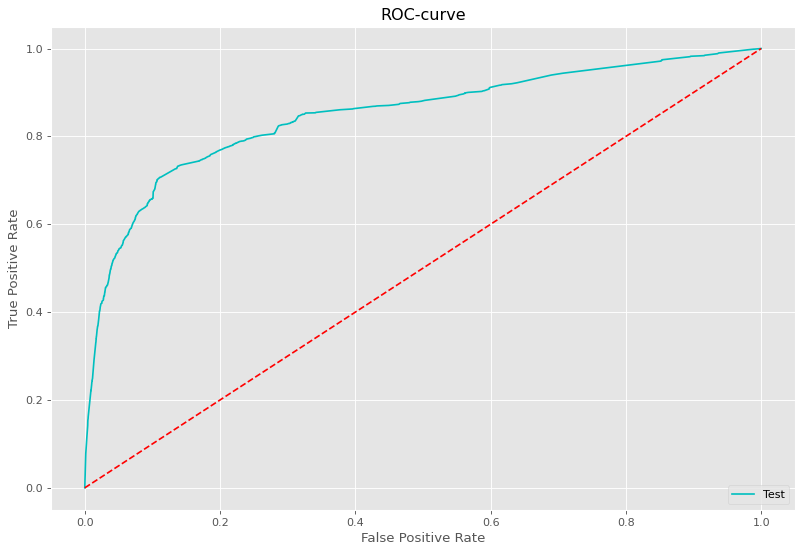

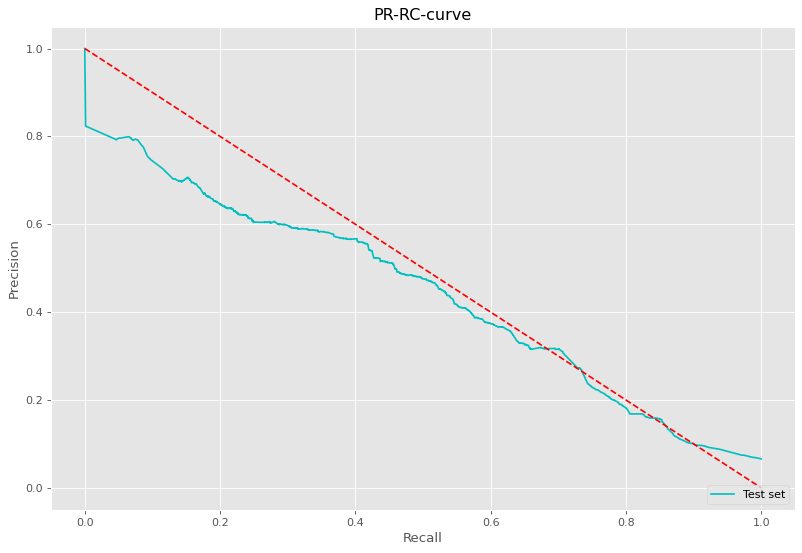

In [76]:
probs = model.predict_proba(X_test)[:,1]

roc_auc_test = roc_auc_score(y_test, probs)
log_loss_test = log_loss(y_test, probs)
# baseline_log_loss = log_loss(y_test_churn, [sum(y_train_churn) / len(y_train_churn)] * len(y_test_churn))
print('Test ROC AUC: {}\nTest Log Loss: {}'.format(round(roc_auc_test,6), round(log_loss_test,6)))
print(confusion_matrix(y_test, (probs > 0.5) * 1))



plt.figure(figsize=(12, 8), dpi=80)
fpr, tpr, threshold = roc_curve(y_test, probs)
plt.plot(fpr, tpr, 'c', label = 'Test')
plt.title('ROC-curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
precision, recall, threshold = precision_recall_curve(y_test, probs)
plt.plot(recall, precision, 'c', label = 'Test set')
plt.title('PR-RC-curve')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [1, 0],'r--')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Conclusion

In this article we compared different approaches for churn modelling, describing their pros and cons. Statistical models and survival analysis provide a good ways for data exploration and understanding your customers better. Whereas machine learning models currently sound better in terms of flexibility, accuracy metrics and churn probability estimation. Anyway, churn prediction is always about how well you understand your customers and it is useful to analyse them from different sides. Sometimes simple model is good to go, sometimes you need some advanced tricks to reach the needed accuracy. No matter what your case is, we are happy to discuss and help with it.
